<span style="color:red; font-size:30px;"> The aim of this code is to extract the form facors computed in arXiv:1503.01421 </span>

======================================================================================================

<span style="color:blue; font-size:30px;"> Extraction of data from the files </span>

======================================================================================================

In [2]:
import csv
from collections import OrderedDict

file_path = '/Users/manuel/Desktop/LambdabLambdac_HO_covariance.dat' 
Cov = OrderedDict()  # Utilizziamo OrderedDict per mantenere l'ordine di inserimento delle chiavi
chiavi_ordinate = []

with open(file_path, 'r') as file:
    reader = csv.reader(file, delimiter=' ')
    for row in reader:
        chiave1 = row[0]
        chiave2 = row[2]
        valore = float(row[4])
        
        if chiave1 not in Cov:
            Cov[chiave1] = {}
            chiavi_ordinate.append(chiave1)
        
        Cov[chiave1][chiave2] = valore

# Stampa delle chiavi ordinate
print(chiavi_ordinate)
print(Cov[chiavi_ordinate[0]][chiavi_ordinate[0]])

file_path2 = '/Users/manuel/Desktop/LambdabLambdac_HO_results.dat'
Mean = OrderedDict()
with open(file_path2, 'r') as file2:
    reader = csv.reader(file2, delimiter=' ')
    for row in reader:
        chiave = row[0]
        valore = float(row[2])
        
        Mean[chiave] = valore
        
print(Mean[chiavi_ordinate[2]])

['a0_fplus', 'a1_fplus', 'a2_fplus', 'a0_f0', 'a1_f0', 'a2_f0', 'a0_fperp', 'a1_fperp', 'a2_fperp', 'a0_gpp', 'a1_gplus', 'a2_gplus', 'a0_g0', 'a1_g0', 'a2_g0', 'a1_gperp', 'a2_gperp']
0.000762429069378
0.78618045366394


======================================================================================================

<span style="color:blue; font-size:30px;"> Generation of the distribution from a gaussian multivariate </span>

======================================================================================================

In [3]:
import numpy as np
Nboot = 1000

# Ottieni la lista delle chiavi ordinate dal dizionario Cov
chiavi_ordinate = list(Cov.keys())

# Ottieni la dimensione della matrice di covarianza
dimensione = len(chiavi_ordinate)

# Crea una matrice di covarianza vuota
covarianza = np.zeros((dimensione, dimensione))
Media = np.zeros(dimensione)

# Riempire la matrice di covarianza con i valori corrispondenti dal dizionario Cov
for i in range(dimensione):
    chiave1 = chiavi_ordinate[i]
    Media[i] = Mean[chiave1]
    for j in range(dimensione):
        chiave2 = chiavi_ordinate[j]
        valore = Cov[chiave1][chiave2]
        covarianza[i, j] = valore

# Genera i campioni casuali dalla distribuzione gaussiana multivariata
campioni = np.random.multivariate_normal(mean=Media, cov=covarianza, size=Nboot)

# Crea un dizionario con i nomi corrispondenti ai campioni
campioni_dict = {}
for i in range(dimensione):
    chiave = chiavi_ordinate[i]
    campioni_dict[chiave] = campioni[:, i]

# Stampa i campioni generati come dizionario
#print(campioni_dict)
print(campioni_dict['a0_fplus'][0])
print(len(campioni_dict))
#print(campioni_dict)

0.7170106567581273
17


======================================================================================================

<span style="color:blue; font-size:30px;"> Definition of the functions for the computation of the ffs </span>

$f_{HO}(q^2) = \frac{1}{1-q^2/(m^f_{pole})^2}\big[ a_0^f + a_1^f z^f(q^2) + a_2^f [z^f(q^2)]^2 \big]$

where 

$z^f(q^2) = \frac{\sqrt{t_+^f-q^2}-\sqrt{t_+^f-t_0}}{\sqrt{t_+^f - q^2}+-\sqrt{t_+^f-t_0}}$

======================================================================================================

In [4]:
def zf(tp_, q2_, tz_):
    return (np.sqrt(tp_-q2_)-np.sqrt(tp_-tz_))/(np.sqrt(tp_-q2_)+np.sqrt(tp_-tz_))
    
def ff_f(q2_, Mpole_, tp_, tz_, a0_, a1_, a2_):
    return 1/( 1 - q2_/(Mpole_**2) )*( a0_ + a1_*zf(tp_,q2_,tz_) + a2_*zf(tp_,q2_,tz_)**2 )

======================================================================================================

<span style="color:blue; font-size:30px;"> Definition of the relevant quantities </span>

$t_0 = (m_{\Lambda_b}-m_{\Lambda_c})^2,$

$m_{pole} = m_{B_c} + \Delta^f$, (see Table VII of the paper),

$t_+ = (m_{pole})^2.$

======================================================================================================

In [5]:
MBc = 6.276
MLb = 5.6202
MLc = 2.28646

ff_str = ['fplus', 'f0', 'fperp', 'gplus', 'g0', 'gperp']
ff = {'fplus': 0.056, 'f0': 0.449, 'fperp': 0.056, 'gplus': 0.492, 'g0': 0, 'gperp': 0.492}
print(ff)

# Aggiungo MBc alle delta
Mpole = {}
tp = {}
for chiave in ff:
    Mpole[chiave] = ff[chiave] + MBc
    tp[chiave] = Mpole[chiave]**2

tz = ( MLb - MLc )**2

print(Mpole)
print(tp)

{'fplus': 0.056, 'f0': 0.449, 'fperp': 0.056, 'gplus': 0.492, 'g0': 0, 'gperp': 0.492}
{'fplus': 6.332, 'f0': 6.725, 'fperp': 6.332, 'gplus': 6.768, 'g0': 6.276, 'gperp': 6.768}
{'fplus': 40.094224, 'f0': 45.225624999999994, 'fperp': 40.094224, 'gplus': 45.805823999999994, 'g0': 39.388175999999994, 'gperp': 45.805823999999994}


======================================================================================================

<span style="color:blue; font-size:30px;"> Computation of the FFs </span>

======================================================================================================

In [7]:
ff_comp = {}

bins = np.arange(0, tz, 0.1)

for b in range(len(bins)):
    for j in range(6):
        chiave = ff_str[j]  
        chiave0 = chiave
        if chiave == 'gplus' or chiave == 'gperp':
            chiave0 = 'gpp'
        if chiave not in ff_comp:
            ff_comp[chiave] = {}
        for i in range(Nboot):
            if i not in ff_comp[chiave]:
                ff_comp[chiave][i] = {}
            ff_comp[chiave][b][i] = ff_f(bins[b], Mpole[chiave], tp[chiave], tz, campioni_dict[f'a0_{chiave0}'][i], campioni_dict[f'a1_{chiave}'][i], campioni_dict[f'a2_{chiave}'][i])

#print(ff_comp['gperp'][0])

======================================================================================================

<span style="color:blue; font-size:30px;"> Mean and Sigma bootstrap </span>

======================================================================================================

In [8]:
media_bootstrap = {}
sigma_bootstrap = {}

for chiave in ff_str:
    media_bootstrap[chiave] = np.zeros(len(bins))
    sigma_bootstrap[chiave] = np.zeros(len(bins))

    for b in range(len(bins)):
        campioni = [ff_comp[chiave][b][i] for i in range(Nboot)]
        media_bootstrap[chiave][b] = np.mean(campioni)
        sigma_bootstrap[chiave][b] = np.std(campioni)

print(len(bins))
print(media_bootstrap['fperp'][111])

112
1.5118361020167608


======================================================================================================

<span style="color:blue; font-size:30px;"> Plots </span>

======================================================================================================

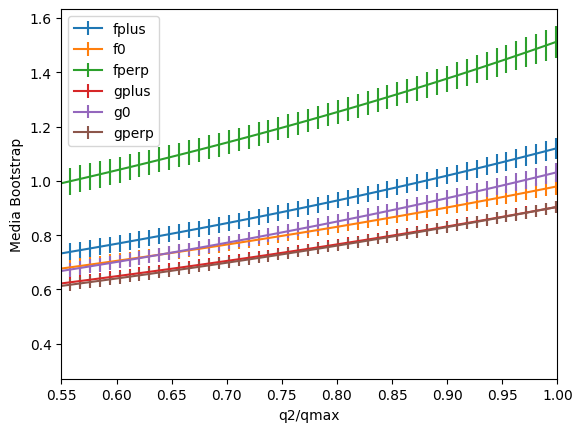

In [9]:
import matplotlib.pyplot as plt

for chiave in ff_str:
    plt.errorbar(bins/tz, media_bootstrap[chiave], yerr=sigma_bootstrap[chiave], label=chiave)

plt.xlabel('q2/qmax')
plt.ylabel('Media Bootstrap')
plt.xlim(0.55, 1)
plt.legend()
plt.show()